# サナララメディア処理の基礎的検討(1)

このドキュメントは、[ぴょこりんクラスタ Advent Calendar 2015](http://www.adventar.org/calendars/960)のために書いたものです。

## はじめに

　ぶっちゃけOpenCV触ってみようと思っただけです。最近Deep Learningもてはやされてて、実際ChainerインストールしてGPGPUもぶん回せることを確認したものの、普通に画像処理方面のことしたことないよねってことで。基本的なところをきちんと触ってからDeep Learningに手を出してみて、じゃないとやっぱり一つ基準みたいなものを最初に持っておかないと、何がすごいってわかんないよねってことで。  
　動かした環境はUbuntuなんだけど、apt-getでlibopencv-devとpython-opencvぶち込んだらオマケで古いnumpyが入ってきて、依存するライブラリ(matplotlibとかscikit-learnとか)が全部動かなくなってひゃっはーってなる呪い付なので注意。pipで動かなくなったやつらをuninstall=>installすると古いバージョンのnumpyに合わせてインストールしてくれるようで、なんとか動くようになるんだけど、何となくopencvのためにnumpyが古くなるというのもねぇ・・・。OpenCV使うときは仮想化かますなり何らかの手段で専用の環境用意した方が良いのかも。というわけでサナララメディア処理はじまるよ！！！
 
## 映像中に複数いるめっちょかわいいヒロイン達を抽出し追従したい
 
 自然なモチベーションです。追従したくない？追従したいよね！！とりあえず映像から女の子たちの顔画像を抽出するよ！一般的に現実は厳しいとされるから、[非現実向けにチューニングされた顔画像検出手法が提案されているよ](http://ultraist.hatenablog.com/entry/20110718/1310965532)。この記事でもこいつを活用させてもらったよ！！

In [6]:
import cv2
vidcap = cv2.VideoCapture('./learningset/snrrrmp4.mp4')
success,image = vidcap.read()
count = 0;
cascade_path ='./lbpcascade_animeface.xml'
cascade = cv2.CascadeClassifier(cascade_path)
inddic={}
while success:
  success,image = vidcap.read()
  facerect = cascade.detectMultiScale(image)
  tmp=[]
  for ind,rect in enumerate(facerect):
    #cv2.rectangle(image, tuple(rect[0:2]),tuple(rect[0:2]+rect[2:4]), color, thickness=2)
    tmp.append(image[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]])
  inddic[count]=tmp
  count += 1

## 特徴量をつくる
### 色の離散化
　画像処理よくわかんないからとりあえず次元削減的な効果を狙ってk-meansで色を離散化するよ。

In [19]:
colors=[l for i in inddic.items() if len(i[1])!=0 for j in i[1] for k in j for l in k]
print len(colors)

33930577


顔画像周辺のドットの総数。それぞれが3次元（色的な意味で）ベクトルを持っていると。これk-meansかけて色を離散化しようぜっていう。
ちょっとデータ多すぎるから1%位に間引くことにする。1％にした理由はそれ以上にすると今晩この計算回すだけで終わってしまうから。

In [38]:
import random
samples=[i for i in colors if random.random()>0.99]
print len(samples)

339651


In [182]:
from sklearn.cluster import KMeans
results=[]
for i in range(5,50):
    k_means = KMeans(n_clusters=i, n_init=4)
    k_means.fit(samples)
    results.append(k_means)
#%matplotlib inline

### Bag of なんちゃら
　顔画像フレームごとに離散化した諸々の色の出現回数を数えてこれを並べて特徴量をつくります。色のヒストグラムなのでBag of Colorsとか言うんでしょうかね。色の頭文字で構成されるサナララにふさわしい特徴量です！

In [168]:
import warnings;warnings.filterwarnings('ignore')
import numpy as np
kmeans=results[35]
print kmeans
data=[(i[0],j) for i in inddic.items() if len(i[1])>0 for j in i[1]]
BoC=[]
for i in data:
    (s1,s2,s3)=i[1].shape
    clusters=kmeans.predict(np.reshape(i[1],(s1*s2,s3)))
    BoC.append([i[0] ,[len(np.where(clusters==s)[0]) for s in range(20)]])
    #print [list(clusters).count(s) for s in range(20)]

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=41, n_init=4,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


## 顔画像自体の分類
眠くなって来たのでちゃちゃっと正規化してGMMにでもかけてみましょう。

In [181]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import KernelPCA
from sklearn.mixture import GMM 
pca=KernelPCA(n_components=25)
X=[i[1] for i in BoC]
preX=normalize(X, norm='l2', axis=1)
pca.fit(preX)
preX=pca.transform(preX)
g = GMM(covariance_type='full',n_components=10)
g.fit(preX)

GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
  n_components=10, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

動画における各フレームごとに、認識された顔画像がどのガウシアンに分類されたか表示する。

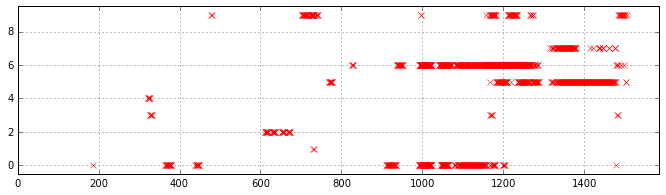

In [179]:
plt.figure(num=None, figsize=(11.5,3),dpi=80,facecolor='w',edgecolor='k')
result=[(s[0], g.predict(pca.transform([s[1]]))[0]) for s in BoC]
#result=[(s[0], g.predict([s[1]])) for s in BoC]
plt.plot([i[0] for i in result],[i[1] for i in result],'rx')
plt.xlim(0,count)
plt.ylim(-0.5,9.5)
plt.grid()
plt.show()


ちなみに使った動画は[これ](https://www.youtube.com/watch?v=iFvruJ98Gl0)。
<iframe width="560" height="315" src="https://www.youtube.com/embed/iFvruJ98Gl0" frameborder="0" allowfullscreen></iframe>

動画長めながら上の図を眺めると、「あーこれはこれかな？」みたいなのがそこそこわかるんだけれど、それにしたってあんまり綺麗に分かれてなひ・・・。希望としては各コンポネントが各キャラに対応して欲しかった（キャラ数＝５よりコンポネント数の方が多いのは５にしたとき結果がクソだったから増やしたということですご察しください）。なかなか難しい。ちなみに１３００フレームはひかる氏が一人で座ってるところなんだけど何故か靴あたりがもう一つ顔として認識されて変なコンポネント（たぶん7番め）ができちゃってたりする。

## 色々やってみて思ったこと
　全部のフレーム顔画像検出して結果を枠で囲んだ画像生成して眺めることも一応やってて、やっぱりこれって正面からで顔全体が見えている画像を対象としていて、横を向いている、目をつむっている、顔の一部が隠れてる、ドアップで輪郭の一部がはみ出てしまってるみたいなケースでは検出出来ないことが多いなぁと感じた。動画の40秒あたりでひかる氏手が顔の両側にあるんだけど、これだけでひかる氏の顔は認識できなくなってたりする。性質上のぞみ先生は顔を何かで隠してることが多くて、こっちもなかなか認識しなくてもうみてるだけでニヤニヤしてるキモヲタでした。
 Bag of Colorsは基本肌色に持ってかれるだろうなぁと思いつつ何か前処理かましてやれば目と髪の色で結構識別出来るかなぁっと思ったんだけど結構いまいち。結果の詳細な分析や考察はまだ出来てないんだけどピンク髪の矢神さんは割と追えてる感じがした。特徴量つくる側では結構えいやとやってしまったのでもうちょいパラメタチューニングの余地があるかも。
 あと、一つ一つのデータを眺めるというクソ単調な作業でも対象に興味があると続けられるんだなぁと思いました。

## まとめ
　動画に対してOpenCVとかscikit-learnとか色々叩いて色々やってみたけど結果は微妙だった。